#  **Final Project - Demographic Analysis of the Academy Award Nominations**
*Notebook IV*

The Oscar Award dataset - Person network

---

> Authors: Sara Kartalovic, Bogdan Milovanovic,  Tarja Savonen<br>
> Date: 19/01/2022 <br>
> Course : Network Science <br>
> Teacher : Tomaso Erseghe <br>
> Co-Teachers : Lejla Dzanko

In [34]:
# Imports

import os
import pandas as pd
import numpy as np
import math as math
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 

import itertools
import networkx as nx

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [35]:
# Mount Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
def degree_freq(G, degree_direction):
    n_nodes = len(G.nodes)
    if degree_direction=='in':
        k_list = np.array([G.in_degree[i] for i in range(n_nodes)])
    elif degree_direction=='out':
        k_list = np.array([G.out_degree[i] for i in range(n_nodes)])
    else:
        k_list = np.array([val for (node, val) in G.degree()])
        
    dmax=max(k_list)+1
    freq= [ 0 for d in range(dmax) ] #[0,0,0,,,,,,0]
    for d in k_list:
        freq[d] += 1
    return (freq, k_list)

plt.show()

def plot_plot(G, degree_direction):
    freq, k_list = degree_freq(G, degree_direction)
       
    mean_degree = round(np.mean(k_list),3) # mean value of degree list
    std_degree = round(np.std(k_list),3) # stdev of degree list
    figure(figsize=(7, 5))

    plt.plot(range(len(freq)),freq, '.')
    plt.xticks(range(0,max(k_list),5))
    plt.xlabel(degree_direction+"-degree, $K_{%s}$"%degree_direction,size=12)
    plt.ylabel('Number of nodes',size=12)
    plt.title(degree_direction+'-degree distribution, $P_{k_{%s}}$'%degree_direction,size=14)
    s = 'n_nodes: '+str(len(k_list))+'\nMean degree: '+str(mean_degree)+'\nSTDEV degree: '+str(std_degree)
    
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    plt.show()


def logPk(logk,logc,gamma):
    return logc - gamma*logk

def plotnfit_Pk(G, degree_direction):    
    freq, k_list = degree_freq(G, degree_direction)
    # k is list of all the degrees present.
    
    k_initial = 1 #we reject all K < K_initial
    # k= [80.....475] for in degree. 
    k = np.array(range(k_initial,max(k_list)+1)) # applying assumption
    # consider only the frequencies for K>=80 where freq=counts for k values of (0,1,2,3,....) in that order
    Pk = np.array(freq[k_initial:])

    # remove zeros from Pk, clean the data since we are applying log function.
    Pk_new = Pk[Pk>0] #Pk[True, True, False, .......]
    # remove all degrees that have 0 frequency
    k_new = k[Pk>0]

    # apply log to do log fitting instead of power law fitting
    x = np.log(k_new)
    y = np.log(Pk_new)
    params,cov = curve_fit(logPk,x,y) # cov is the covariance matrix
    logc = params[0]
    gamma = params[1]

    y_fit = logPk(x,*params)

    figure(figsize=(7, 5))

    plt.loglog(range(len(freq)), freq, '.')
    plt.loglog(np.exp(x),np.exp(y_fit))
    
    # aesthetics
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.5)
    
    # print info on the graph
    s = 'Reject all K < '+str(k_initial)+'\n$\gamma = $ '+str(round(gamma,3))+'\nlog(C) = '+str(round(logc,3))
    # some useful tricks to plot text in the place of legend!!
    plt.plot([],[],label=s)
    legend = plt.legend(handlelength=0, handletextpad=0, fancybox=True,loc='best')
    
    plt.xlabel(degree_direction+"-degree, $k_{%s}$"%degree_direction,size=12)
    plt.ylabel("$P_{k_{%s}}$"%degree_direction,size=12)
    plt.title('log-log plot of %s-degree distribution \nand fit $P_{k_{%s}} = C  K^{-\gamma}_{%s}$'
              %(degree_direction,degree_direction,degree_direction),size=14)
    
    plt.show()

def plot_degree_distr(G, degree_direction):
    plt.figure()
    
    plt.subplot(1,2,1)
    plot_barplot(G, degree_direction)
    
    plt.subplot(1,2,2)
    plotnfit_Pk(G, degree_direction)
    
    #plt.tight_layout()
    plt.show()

In [37]:
oscar_filtered = pd.read_csv('/content/drive/MyDrive/NS/Original Filtered Data/the_oscar_award_filtered.csv')

In [38]:
# Create dataframe that consists of only 5 categories

people_nominated_df = oscar_filtered.loc[(oscar_filtered['category'] == 'ACTOR') | (oscar_filtered['category'] == 'ACTRESS') 
                                        | (oscar_filtered['category'] == 'ACTOR IN A SUPPORTING ROLE') | (oscar_filtered['category'] == 'ACTRESS IN A SUPPORTING ROLE')
                                        | (oscar_filtered['category'] == 'DIRECTING')]
#people_nominated_df = oscar_filtered

In [39]:
#initialize an empty dict
unique_people = {}

for idx, row in people_nominated_df.iterrows():
#for row in oscar.film:
  people = [row['name']]
  for person in people:
    #if the word is encountered for the first time add to dict as key and set its value to 0
    unique_people.setdefault(person,0)
    #increase the value (b.e the count) of the word by 1 every time it is encountered
    unique_people[person] += 1

In [40]:
up_df = pd.DataFrame.from_dict(unique_people, orient='index').reset_index()
up_df.rename(columns = {'index':'Person', 0:'Count'}, inplace=True)
up_df.sort_values(by=['Count'], ascending=False, inplace=True)

In [41]:
# Create dictionary- {film: list of actors}

#initialize an empty dict
name_film_dict = {}

for idx, row in people_nominated_df.iterrows():
#for row in oscar.film:
  people = [row['name']]
  films = [row['film']]

  for person in people:
    for film in films:
      #if the word is encountered for the first time add to dict as key and set its value to 0
      if person not in name_film_dict.keys():
        name_film_dict.setdefault(person,[film])
      else:
        name_film_dict[person].append(film)

In [42]:
# Create network

G = nx.Graph()
edge_attribute_dict = {}

for name, films in name_film_dict.items():
  G.add_node(name)
  for film in films:
    for name2, films2 in name_film_dict.items():
      if (film in films2) and (films2 != films):
        G.add_edge(name, name2)
        name_tuple = tuple(sorted((name, name2)))
        if name_tuple not in edge_attribute_dict:
          edge_attribute_dict.setdefault(name_tuple,0)
        else:
          edge_attribute_dict[name_tuple] +=1

In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edges, weigth in edge_attribute_dict.items():
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edges[0],edges[1],weigth))

G.add_weighted_edges_from(up_weighted)

In [15]:
# Create dataframe from dictionary
name_film_df = pd.DataFrame.from_dict(name_film_dict, orient='index').reset_index()
name_film_df.rename(columns= {'index':'Name', 0:'Film1',1:'Film2',2:'Film3', 3:'Film4', 4:'Film5', 5:'Film6', 
                              6: 'Film7', 7:'Film8', 8:'Film9', 9:'Film10', 10:'Film11', 11:'Film12', 12:'Film13',
                              13:'Film14', 14:'Film15',15:'Film16', 16:'Film17',17:'Film18', 18:'Film19',19:'Film20',
                              20:'Film21'}, inplace= True)
name_film_df = name_film_df.fillna('0')

In [16]:
print(nx.info(G))

Graph with 1161 nodes and 1335 edges


## Add atributes

In [43]:
# Save nodes
nf_df = name_film_df.copy()
nf_df.drop(columns=[column for column in nf_df.columns if column!='Name'], inplace=True)
nf_df.rename(columns={'Name':'Label'}, inplace=True)
nf_df["Id"] = nf_df["Label"]
nf_df.sort_values(by = 'Label', inplace = True)

In [44]:
categories = people_nominated_df[['name', 'category']]
categories.sort_values(by = 'name', inplace = True)

node_att_df = pd.merge(
    left = nf_df,
    right = categories, how = 'left', left_on='Label', right_on= 'name')

del node_att_df['name']
node_att_df = node_att_df.drop_duplicates('Label')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [45]:
# Save edges
nx.write_weighted_edgelist(G, "./name_film_full_edgelist.csv", delimiter=",")

# Save nodes
att_df = node_att_df.copy()
att_df.to_csv("name_film_full_nodelist.csv")

# Network Analysis


## Degree distribution

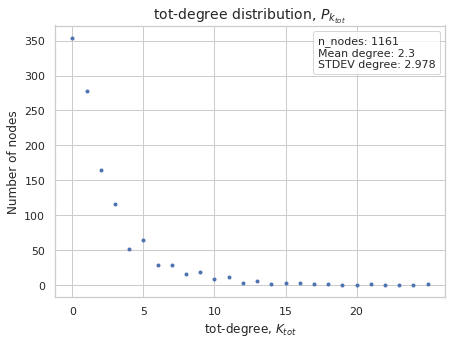

In [57]:
plot_plot(G,'tot')

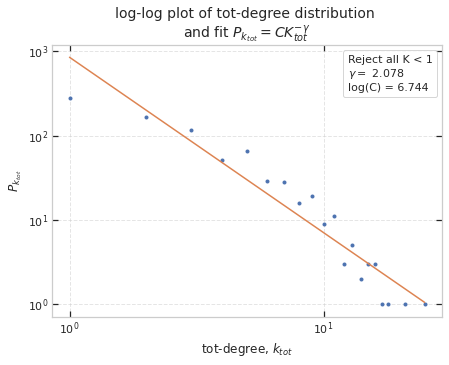

In [58]:
plotnfit_Pk(G,'tot')

## Shorthest Path (NO WEIGHTS)

(0.0, 20.0)

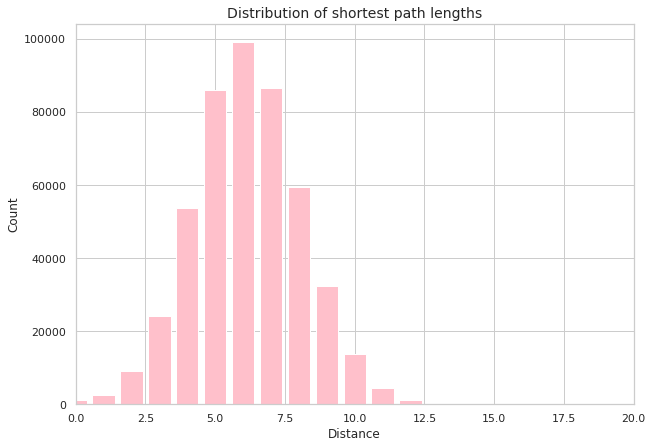

In [48]:
# Find path lengths
length_source_target = dict(nx.shortest_path_length(G, weight = 'weight'))

# Convert dict of dicts to flat list
all_shortest = sum([
list(length_target.values())
for length_target
in length_source_target.values()],
[])
# Calculate integer bins
high = max(all_shortest)
bins = [-0.5 + i for i in range(high + 2)]

# Plot histogram
plt. figure(figsize=(10,7))
plt.hist(all_shortest, bins=bins, rwidth=0.8, color = 'pink')
plt.title("Distribution of shortest path lengths", size=14)
plt.xlabel("Distance", size=12)
plt.ylabel("Count", size=12)
plt.xlim(0,20)

## Centrality measurements

### Page Rank

In [49]:
page_rank = nx.pagerank(G, alpha = 0.8, weight = 'weight') 

sorted_page_rank = sorted(page_rank.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by Page rank:")
for b in sorted_page_rank[:10]:
    print(b)

Top 10 nodes by Page rank:
('William Wyler', 0.006019203971937923)
('Jack Nicholson', 0.005592343820534367)
('Meryl Streep', 0.0040897293579326525)
('Marlon Brando', 0.0036652438567833967)
('Dustin Hoffman', 0.003657614076873938)
('Katharine Hepburn', 0.003654535212436855)
('Paul Newman', 0.0036023393096973775)
('Robert De Niro', 0.003584472955358688)
('Warren Beatty', 0.003450596724176638)
('Irene Dunne', 0.003355195575970804)


### Betweenness centrality

In [50]:
betweenness_dict = nx.betweenness_centrality(G, weight = 'weight') # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G, weight = 'weight') # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [51]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b)

Top 10 nodes by betweenness centrality:
('Meryl Streep', 0.05200982834384383)
('Jack Nicholson', 0.047852285858999005)
('William Wyler', 0.04271897324213377)
('Katharine Hepburn', 0.042563328447718506)
('Robert De Niro', 0.03411001376844498)
('Martin Scorsese', 0.032520610979033374)
('John Huston', 0.03245100216526022)
('Jane Fonda', 0.031501327207812395)
('Fred Zinnemann', 0.028977923837923993)
('Paul Newman', 0.025101793433054447)


In [52]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b)

Top 10 nodes by eigenvector centrality:
('Bradley Cooper', 0.3253640803516134)
('Judy Garland', 0.28878976253760186)
('Fredric March', 0.2603355479549582)
('James Mason', 0.2516899470460395)
('William Wellman', 0.23870686434887878)
('Janet Gaynor', 0.2340479766271986)
('Sam Elliott', 0.20687842435090562)
('Lady Gaga', 0.20687842435090562)
('Robert De Niro', 0.2003064803378513)
('Amy Adams', 0.13996173240710222)


### Closeness Centrality

In [53]:
close_centrality = nx.closeness_centrality(G) #does not need weights

sorted_centrality = sorted(close_centrality.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by closeness centrality:")
for d in sorted_centrality[:10]:
    print(d)

Top 10 nodes by closeness centrality:
('Jack Nicholson', 0.13938671722720344)
('Meryl Streep', 0.1385324574689162)
('John Huston', 0.13801554531418145)
('Jane Fonda', 0.13740960067078922)
('Katharine Hepburn', 0.13607686541344713)
('William Wyler', 0.13432480276863878)
('Robert De Niro', 0.13309448072823254)
('Fred Zinnemann', 0.13240150588552127)
('Sidney Lumet', 0.13205771748984318)
('Bradley Cooper', 0.13103698150924536)


In [54]:
closeness = pd.DataFrame.from_dict(sorted_centrality) #closeness centrality
closeness.columns =['Node', 'Closeness centrality'] 
closeness['Closeness centrality'] = (closeness['Closeness centrality'] - min(closeness['Closeness centrality']))/(max(closeness['Closeness centrality'])- min(closeness['Closeness centrality']))

eigenvec = pd.DataFrame.from_dict(sorted_eigenvector)
eigenvec.columns =['Node', 'Eigenvector centrality'] 
eigenvec['Eigenvector centrality'] = (eigenvec['Eigenvector centrality'] - min(eigenvec['Eigenvector centrality']))/(max(eigenvec['Eigenvector centrality'])- min(eigenvec['Eigenvector centrality']))


betweenness = pd.DataFrame.from_dict(sorted_betweenness)
betweenness.columns =['Node', 'Betweenness centrality'] 
betweenness['Betweenness centrality'] = (betweenness['Betweenness centrality'] - min(betweenness['Betweenness centrality']))/(max(betweenness['Betweenness centrality'])- min(betweenness['Betweenness centrality']))

page_rank = pd.DataFrame.from_dict(sorted_page_rank)
page_rank.columns =['Node', 'Page Rank centrality'] 
page_rank['Page Rank centrality'] = (page_rank['Page Rank centrality'] - min(page_rank['Page Rank centrality']))/(max(page_rank['Page Rank centrality'])- min(page_rank['Page Rank centrality']))

closeness = closeness[0:5]
eigenvec = eigenvec[0:5]
betweenness = betweenness[0:5]
page_rank = page_rank[0:5]

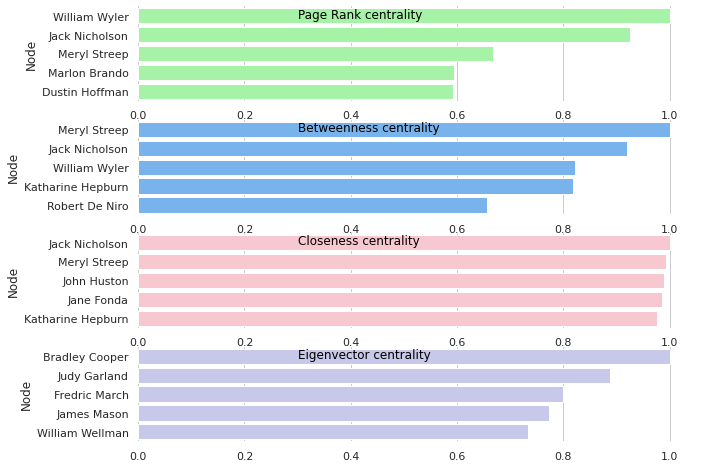

In [55]:
# Initialize the matplotlib figure

fig, (ax3, ax4, ax5, ax6) = plt.subplots(4,figsize=(10, 8) )

sns.set(style="whitegrid")

sns.barplot(x='Closeness centrality', y="Node",data=closeness,
            color="pink", orient = 'h',order=closeness.sort_values('Closeness centrality', ascending=False)['Node'] , ax = ax5)
ax5.text(0.3, 0.1,'Closeness centrality', c = "Black")
ax5.xaxis.label.set_visible(False)

sns.barplot(x='Eigenvector centrality', y="Node",data=eigenvec,
            color='#c2c2f0', orient = 'h',order=eigenvec.sort_values('Eigenvector centrality', ascending=False)['Node'] , ax = ax6)
ax6.text(0.3, 0.10,'Eigenvector centrality', c = "Black")
ax6.xaxis.label.set_visible(False)

sns.barplot(x= 'Betweenness centrality', y="Node",data=betweenness,
            color='#66b3ff', orient = 'h',order=betweenness.sort_values('Betweenness centrality', ascending=False)['Node'] , ax = ax4)
ax4.text(0.3, 0.10,'Betweenness centrality', c = "Black")
ax4.xaxis.label.set_visible(False)

sns.barplot(x='Page Rank centrality', y="Node",data=page_rank,
            color="#99ff99", orient = 'h',order=page_rank.sort_values('Page Rank centrality', ascending=False)['Node'] , ax = ax3)
ax3.text(0.3, 0.10,'Page Rank centrality', c = "Black")
ax3.xaxis.label.set_visible(False)

sns.despine(left=True, bottom=True)